**Overview**

The purpose of this script is to apply Weibull curve fitting to the PMBR and plot the results

**Import dependencies**

In [ ]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import scipy.optimize as sciopt
import scipy.stats as stats
import random
import seaborn as sns


**Set fitting parameters**

In [ ]:
plotOK = False 
fRange = (15,30)
fs = 100	# Hz
numPermute = 1000
epochsInEachPerm = 500


**Define Weibull equation**

In [11]:
def wbl_function(t,C,b,lmbda,k):
	wbl = C*(k/lmbda)*(t/lmbda)**(k-1)*np.exp(-(t/lmbda)**k)+b
	return wbl

**Import data**

In [12]:
# Import relevant TFRs for long ISI trials
data_path = os.path.join("/media/NAS/lbailey/PMBR_timecourse/output/1BP15")

data = np.load(os.path.join(data_path, 'tfr_data_BP_617_subjects.npy'))	# epochs x channels x freq x time
times = np.load(os.path.join(data_path, 'bp_times.npy')) 
freqs = np.load(os.path.join(data_path, 'bp_freqs.npy')) 

data.shape

(626, 2, 39, 1601)

In [8]:
# Get some useful data variables
numEpochs = data.shape[0]
numSamples = times.shape[0]

# Get the frequency band of interest
a = freqs>=fRange[0]
b = freqs<=fRange[1]
c = a*b
bandInd = np.where(c)[0]

In [9]:
# Average across the frequency band of interest
bandData = np.mean(data[:,:,bandInd,:], axis=2)

**Define a function to compute the grand-average timecourse from a given set of epochs, and crop it to the start of the beta rebound**

In [15]:
def get_sensData_crop(bandData, channel):

    # Average over random subset of epochs
    bandAvg = np.mean(bandData,axis=0)

    # Take a baseline as the mean value after 10s
    baseInd = np.where(times>10)[0]
    baseValue = np.mean(bandAvg[:,baseInd],axis=1)
    bandAvg_DC = bandAvg-np.tile(np.expand_dims(baseValue,axis=1),(1,numSamples))

    # Focus on data from one channel
    sensData = bandAvg_DC[channel,:]

    # Get variability in the last few seconds
    powerSD = np.std(sensData[baseInd])

    # Crop data before the second zero-crossing (this removes the suppression portion)
    zero_crossings = np.where(np.diff(np.sign(sensData)))[0]
    sensData_crop = sensData[zero_crossings[1]:-1]
    times_shift = np.arange(sensData_crop.shape[0])/fs

    return sensData_crop, zero_crossings, times_shift, powerSD



**Compute grand-average beta timecourse following beta suppression, for each channel**

In [16]:
ch0_gavg, _, times_shift_ch0, _ = get_sensData_crop(bandData, 0)
ch1_gavg, _, times_shift_ch1, _ = get_sensData_crop(bandData, 1)

**Permute through random samples of the data. On each permutation, compute a grand average and fit with a Weibull curve**

In [ ]:
# Define empty lists to store zero crossings and fit parameters (from each perm)
allZeros_ch0 = []
allZeros_ch1 = []
allPopts_ch0 = []
allPopts_ch1 = []

# Loop through channels
for channel in [0,1]:

    if channel == 0:
        allZeros = allZeros_ch0
        allPopts = allPopts_ch0
    elif channel == 1:
        allZeros = allZeros_ch1
        allPopts = allPopts_ch1

    # Loop through permutations
    for i in np.arange(numPermute):

        # Pick some epochs randomly
        epochList = np.arange(numEpochs)
        random.shuffle(epochList)
        permTrials = epochList[0:epochsInEachPerm]

        # Get cropped data from this random subset of epochs
        sensData_crop, zero_crossings, times_shift, powerSD = get_sensData_crop(bandData[permTrials,:,:], 0)

        # Find the best fit weibull curve parameters
        C0 = 10e-25
        b0 = -1e-25
        lmbda0 = 1.0
        k0=1.4
        popt, pcov = sciopt.curve_fit(wbl_function, times_shift, sensData_crop, p0=[C0,b0,lmbda0,k0])

        # Make the best fit weibull curve
        bestWBL = wbl_function(times_shift,popt[0],popt[1],popt[2],popt[3])

        # Get the +1SD crossings for this fit - this finds two of them
        #	one at the start and one when the PMBR ends
        fitZeros = np.where(np.diff(np.sign(bestWBL-powerSD)))[0]+zero_crossings[1]

        allPopts.append(popt)
        allZeros.append(fitZeros)

# Throw away "zero" times that are less than 2 seconds (these are when the PMBR starts)
# allZeros = np.concatenate( allZeros, axis=0 ) / fs
allZeros_ch0 = np.concatenate( allZeros_ch0, axis=0 ) / fs
allZeros_ch1 = np.concatenate( allZeros_ch1, axis=0 ) / fs 

baselineReturn_ch0 = allZeros_ch0[np.where(allZeros_ch0>2)[0]] 
baselineReturn_ch1 = allZeros_ch1[np.where(allZeros_ch1>2)[0]] 


**Save popts to disk**

In [ ]:
# Save allPops and allZeros to disk
np.save(os.path.join(data_path, 'Weibull_allPopts_ch0.npy'), allPopts_ch0) 
np.save(os.path.join(data_path, 'Weibull_allPopts_ch1.npy'), allPopts_ch1) 

np.save(os.path.join(data_path, 'Weibull_allZeros_ch0.npy'), allZeros_ch0) 
np.save(os.path.join(data_path, 'Weibull_allZeros_ch1.npy'), allZeros_ch1) 

In [18]:
# Load from disk
allPopts_ch0 = np.load(os.path.join(data_path, 'Weibull_allPopts_ch0.npy')) 
allPopts_ch1 = np.load(os.path.join(data_path, 'Weibull_allPopts_ch1.npy')) 

allZeros_ch0 = np.load(os.path.join(data_path, 'Weibull_allZeros_ch0.npy')) 
allZeros_ch1 = np.load(os.path.join(data_path, 'Weibull_allZeros_ch1.npy')) 

baselineReturn_ch0 = allZeros_ch0[np.where(allZeros_ch0>2)[0]] 
baselineReturn_ch1 = allZeros_ch1[np.where(allZeros_ch1>2)[0]] 

**Plot the grand-average data and permuted Weibull curves**

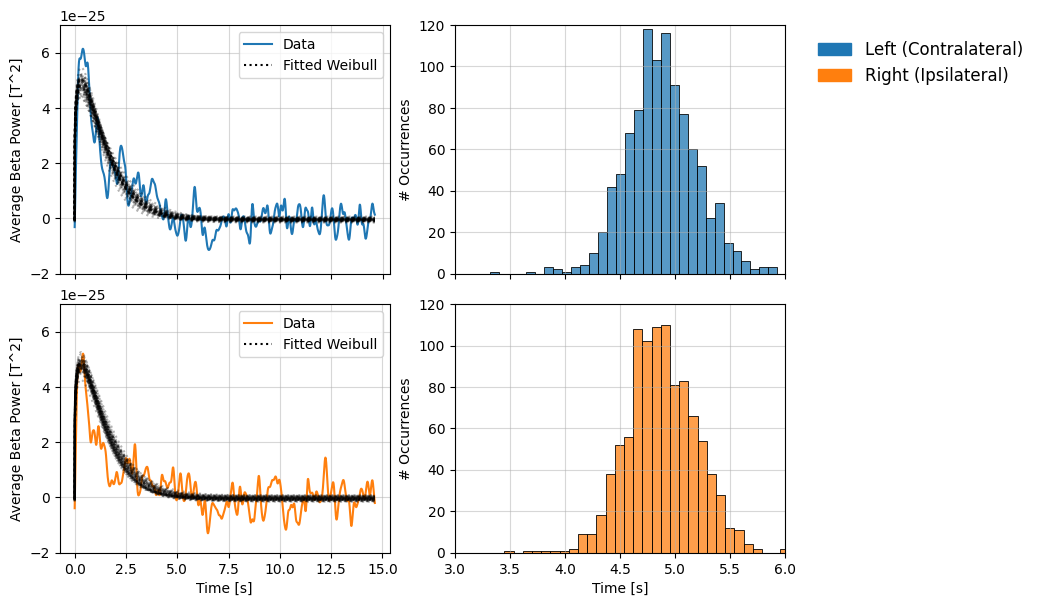

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(8,6))

# Define colours for plotting (one for each channel)
colours = ['#1f77b4', '#ff7f0e'] 

for channel in [0,1]:

	# Get data for this channel
	gavg_data = eval(f'ch{channel}_gavg')
	times_shift = eval(f'times_shift_ch{channel}')
	allPopts = eval(f'allPopts_ch{channel}')
	baselineReturn = eval(f'baselineReturn_ch{channel}')

	baselineReturn_round = np.round(baselineReturn, 2)
	
	# Plot the band limited power & weibull over time (baseline corrected & cropped)
	sns.lineplot(x=times_shift, y=gavg_data, color=colours[channel], ax=axs[channel, 0])

	# Plot every 20th weibull fit
	for popt in allPopts[0::20]:
		bestWBL = wbl_function(times_shift,popt[0],popt[1],popt[2],popt[3])
		sns.lineplot(x=times_shift, y=bestWBL, color='k', linestyle=':', alpha = 0.3, ax=axs[channel, 0])

	# Plot distribution of returns to baseline
	sns.histplot(baselineReturn, color = colours[channel], ax=axs[channel, 1])


	# Add legend
	labels = ['Data', 'Fitted Weibull']
	handles = [plt.Line2D([0], [0], color=colours[channel], linestyle='-'), plt.Line2D([0], [0], color='k', linestyle=':')]
	axs[channel, 0].legend(handles, labels)


	# Set up "shared" x and y axes

	timecourse_ylims = (-2e-25, 7e-25)
	hist_ylims = (0, 120)
	hist_xlims = (3, 6) 

	# Parameters for the timecourse plot (first column)
	axs[channel, 0].set_ylabel('Average Beta Power [T^2]')
	axs[channel, 0].grid(alpha=0.5)

# 	handles, labels = axs[channel, 0].get_legend_handles_labels()
# 	print(handles, labels)
	
	# legend(['Data', 'Model'])
	axs[channel, 0].set_ylim(timecourse_ylims[0], timecourse_ylims[1])

	if channel == 0:
		axs[channel, 0].set_xlabel(None)
		axs[channel, 0].set_xticklabels([])
		# axs[channel, 0].set_title('Weibull Fits to ' + str(numPermute) + ' Random ' + str(epochsInEachPerm) + '-Epoch Averages')
	
	elif channel == 1:
		axs[channel, 0].set_xlabel('Time [s]')
		axs[channel, 0].set_title(None)

	# Parameters for the histogram plot (second column)
	axs[channel, 1].grid(alpha=0.5)
	axs[channel, 1].set_ylabel('# Occurrences')
	axs[channel, 1].set_ylim(hist_ylims[0], hist_ylims[1])
	axs[channel, 1].set_xlim(hist_xlims[0], hist_xlims[1])

	if channel == 0:
		axs[channel, 1].set_xlabel(None)
		axs[channel, 1].set_xticklabels([])
		# axs[channel, 1].set_title('Distribution of Times for Weibull Fits to Return to +1SD from Baseline')

	elif channel == 1:
		axs[channel, 1].set_xlabel('Time [s]')
		axs[channel, 1].set_title(None)

# Create a legend for the figure
labels = ['Left (Contralateral)', 'Right (Ipsilateral)']
contra_patch = mpatches.Patch(color=colours[0], label='Contralateral')
ipsi_patch = mpatches.Patch(color=colours[1], label='Ipsilateral')
handles = [contra_patch, ipsi_patch]

fig.legend(handles, labels, bbox_to_anchor=(1, 0.9), loc='center left', frameon=False, prop={'size': 12})


# Adjust layout
plt.tight_layout(pad=0.5)
plt.show()




**Print descriptive stats**

In [22]:
# How many occurences are below 3.5 s?
print('# Occurrences < 3.5 in Channel 0:', len(np.where(baselineReturn_ch0<3.5)[0]))
print('# Occurrences < 3.5 in Channel 1:', len(np.where(baselineReturn_ch1<3.5)[0]))

# What percentage of occurances are > 4s and < 5.5s?
print('# Occurrences > 4s and < 5.5s in Channel 0:', 
      len(np.where((baselineReturn_ch0>4) & (baselineReturn_ch0<5.5))[0])/len(baselineReturn_ch0)*100)

print('# Occurrences > 4s and < 5.5s in Channel 1:', 
      len(np.where((baselineReturn_ch1>4) & (baselineReturn_ch1<5.5))[0])/len(baselineReturn_ch1)*100)

# Occurrences < 3.5 in Channel 0: 1
# Occurrences < 3.5 in Channel 1: 1
# Occurrences > 4s and < 5.5s in Channel 0: 95.89999999999999
# Occurrences > 4s and < 5.5s in Channel 1: 97.1
